In [ ]:
#hide
# default_exp modelling

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

# modelling
> Modelling the response of the retinal cells to the stimuli

In [ ]:
# Imports required for the documentation and smooth running
# of the jupyter notebook, but not needed in the source code
from theonerig.core import *
from theonerig.processing import *
from theonerig.utils import *
from theonerig.plotting import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

In [ ]:
#export
import math
import scipy as sp
import scipy.optimize
from scipy.interpolate import interp1d
import numpy as np
from functools import partial

# Functions used for modelling

In [ ]:
#export
_default_sigmoid_p = (1,1,0,0)
def sigmoid(x, sigma, amp, x0, y0):
    """Sigmoid function
    params:
        - x: 1D numpy array at which to evaluate the points
        - sigma: steepness of the sigmoid
        - amp: amplitude of the sigmoid
        - x0: shift in x of the sigmoid
        - y0: shift in y of the sigmoid
    """
    return amp / (1.0 + np.exp(-sigma*(x-x0))) + y0

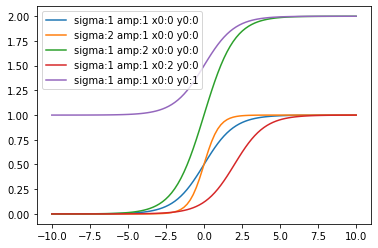

In [ ]:
# Examples of sigmoids
x = np.linspace(-10,10,100)
plt.figure()
plt.plot(x, sigmoid(x, sigma=1, amp=1, x0=0, y0=0), label="sigma:1 amp:1 x0:0 y0:0")
plt.plot(x, sigmoid(x, sigma=2, amp=1, x0=0, y0=0), label="sigma:2 amp:1 x0:0 y0:0")
plt.plot(x, sigmoid(x, sigma=1, amp=2, x0=0, y0=0), label="sigma:1 amp:2 x0:0 y0:0")
plt.plot(x, sigmoid(x, sigma=1, amp=1, x0=2, y0=0), label="sigma:1 amp:1 x0:2 y0:0")
plt.plot(x, sigmoid(x, sigma=1, amp=1, x0=0, y0=1), label="sigma:1 amp:1 x0:0 y0:1")
_ = plt.legend()

In [ ]:
#export
_default_gaussian_p = (1,1,0,0)
def gaussian(x, sigma, amp, x0, y0):
    """Gaussian function
    params:
        - x: 1D numpy array at which to evaluate the points        
        - sigma: width of the gaussian
        - amp: amplitude of the gaussian
        - x0: shift in x of the gaussian
        - y0: shift in y of the gaussian
    """
    return amp * np.exp(-(x-x0)**2 / (2*sigma**2)) + y0

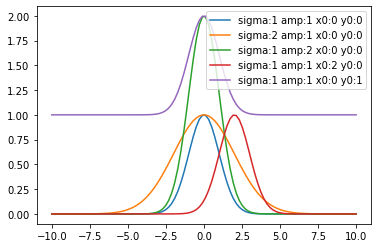

In [ ]:
# Examples of gaussians
x = np.linspace(-10,10,100)
plt.figure()
plt.plot(x, gaussian(x, sigma=1, amp=1, x0=0, y0=0), label="sigma:1 amp:1 x0:0 y0:0")
plt.plot(x, gaussian(x, sigma=2, amp=1, x0=0, y0=0), label="sigma:2 amp:1 x0:0 y0:0")
plt.plot(x, gaussian(x, sigma=1, amp=2, x0=0, y0=0), label="sigma:1 amp:2 x0:0 y0:0")
plt.plot(x, gaussian(x, sigma=1, amp=1, x0=2, y0=0), label="sigma:1 amp:1 x0:2 y0:0")
plt.plot(x, gaussian(x, sigma=1, amp=1, x0=0, y0=1), label="sigma:1 amp:1 x0:0 y0:1")
_ = plt.legend()

In [ ]:
#export
def sum_of_gaussian(t, sigma_1, amp_1, x0_1, 
                       sigma_2, amp_2, x0_2, y0):
    """
    Sum of gaussian, using `gaussian`
    params:
        - t: 1D numpy array at which to evaluate the points        
        - sigma_1: width of the 1st gaussian
        - amp_1: amplitude of the 1st gaussian
        - x0_1: shift in x of the 1st gaussian
        - sigma_2: width of the 2nd gaussian
        - amp_2: amplitude of the 2nd gaussian
        - x0_2: shift in x of the 2nd gaussian
        - y0: shift in y of the gaussian (shared for the two gaussians)"""
    return (gaussian(t, sigma_1, amp_1, x0_1, 0) 
            + gaussian(t, sigma_2, amp_2, x0_2, 0) + y0)

def diff_of_gaussian(t, sigma_1, amp_1, x0_1,
                       sigma_2, amp_2, x0_2, y0):
    """
    Difference of gaussian, using `gaussian`
    params:
        - t: 1D numpy array at which to evaluate the points
        - sigma_1: width of the 1st gaussian
        - amp_1: amplitude of the 1st gaussian
        - x0_1: shift in x of the 1st gaussian
        - sigma_2: width of the 2nd gaussian
        - amp_2: amplitude of the 2nd gaussian
        - x0_2: shift in x of the 2nd gaussian
        - y0: shift in y of the gaussian (shared for the two gaussians)"""
    return (gaussian(t, sigma_1, amp_1, x0_1, 0)
            - gaussian(t, sigma_2, amp_2, x0_2, 0) ) + y0

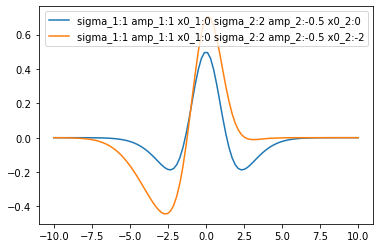

In [ ]:
# Examples of sum of gaussians
x = np.linspace(-10,10,100)
plt.figure()
plt.plot(x, sum_of_gaussian(x, sigma_1=1, amp_1=1, x0_1=0, 
                       sigma_2=2, amp_2=-0.5, x0_2=0, y0=0), label="sigma_1:1 amp_1:1 x0_1:0 sigma_2:2 amp_2:-0.5 x0_2:0")

plt.plot(x, sum_of_gaussian(x, sigma_1=1, amp_1=1, x0_1=0, 
                       sigma_2=2, amp_2=-0.5, x0_2=-2, y0=0), label="sigma_1:1 amp_1:1 x0_1:0 sigma_2:2 amp_2:-0.5 x0_2:-2")
_ = plt.legend()

In [ ]:
#export
_default_2Dgaussian_p = (1,1,1,0,0,0,0)
def gaussian_2D(xz, sigma_x, sigma_z, amp, theta, x0, z0, y0):
    """Two dimensional Gaussian function
    params:
        - xz: meshgrid of x and z coordinates at which to evaluate the points
        - sigma_x: width of the gaussian
        - sigma_z: height of the gaussian
        - amp: amplitude of the gaussian
        - theta: angle of the gaussian (in radian)
        - x0: shift in x of the gaussian
        - z0: shift in z of the gaussian
        - y0: shift in y of the gaussian
    """
    (x,z) = xz
    x0, z0 = float(x0), float(z0)
    a =  (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_z**2)
    b = -(np.sin(2*theta)) /(4*sigma_x**2) + (np.sin(2*theta)) /(4*sigma_z**2)
    c =  (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_z**2)
    g = amp * np.exp( -(a*((x-x0)**2) + 2*b*(x-x0)*(z-z0) + c*((z-z0)**2))) + y0
    return g.ravel()

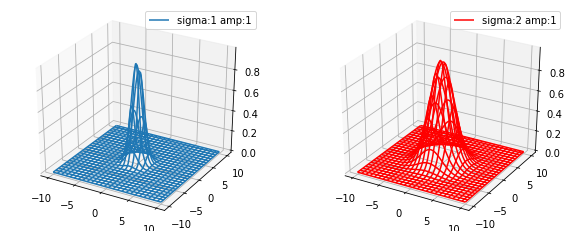

In [ ]:
x,y = np.meshgrid(np.linspace(-10,10,100),np.linspace(-10,10,100))
fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(121, projection='3d')
z = gaussian_2D((x,y), sigma_x=1, sigma_z=1, amp=1, theta=0, x0=0, z0=0, y0=0).reshape(100,100)
ax.plot_wireframe(x, y, z, rstride=4, cstride=4, label="sigma:1 amp:1")
_ = ax.legend()

ax = fig.add_subplot(122, projection='3d')
z = gaussian_2D((x,y), sigma_x=2, sigma_z=2, amp=1, theta=0, x0=0, z0=0, y0=0).reshape(100,100)
ax.plot_wireframe(x, y, z, rstride=4, cstride=4, label="sigma:2 amp:1", color='r')
_ = ax.legend()

In [ ]:
#export
def sum_of_2D_gaussian(xz, sigma_x_1, sigma_z_1, amp_1, theta_1, x0_1, z0_1,
                           sigma_x_2, sigma_z_2, amp_2, theta_2, x0_2, z0_2, y0):
    """Sum of two 2D Gaussian function. For the params, see `gaussian_2D`.
     However, both share the y0 parameter."""
    return (gaussian_2D(xz, sigma_x_1, sigma_z_1, amp_1, theta_1, x0_1, z0_1, 0) 
            + gaussian_2D(xz, sigma_x_2, sigma_z_2, amp_2, theta_2, x0_2, z0_2, 0) + y0)

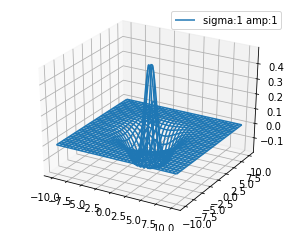

In [ ]:
x,y = np.meshgrid(np.linspace(-10,10,100),np.linspace(-10,10,100))
fig = plt.figure(figsize=(5,4))

ax = fig.add_subplot(111, projection='3d')
z = sum_of_2D_gaussian((x,y), sigma_x_1=1, sigma_z_1=1, amp_1=1, theta_1=0, x0_1=0, z0_1=0,
                           sigma_x_2=2, sigma_z_2=2, amp_2=-0.5, theta_2=0, x0_2=0, z0_2=0, y0=0).reshape(100,100)
ax.plot_wireframe(x, y, z, rstride=3, cstride=3, label="sigma:1 amp:1")
_ = ax.legend()

In [ ]:
#export
def exponential_decay(x, tau, baseline, amplitude):
    """Exponential decay function
    params:
        - x: 1D numpy array at which to evaluate the points        
        - tau: decay speed
        - baseline: baseline after the decay. Must be lower than the amplitude
        - amplitude: Initial amplitude before the decay
    """
    return np.exp(-x*tau)*(amplitude-baseline) + baseline

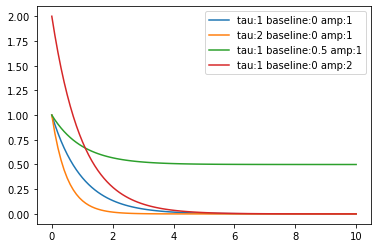

In [ ]:
# Examples of sum of gaussians
x = np.linspace(0,10,100)
plt.figure()
plt.plot(x, exponential_decay(x, tau=1, baseline=0, amplitude=1), label="tau:1 baseline:0 amp:1")
plt.plot(x, exponential_decay(x, tau=2, baseline=0, amplitude=1), label="tau:2 baseline:0 amp:1")
plt.plot(x, exponential_decay(x, tau=1, baseline=.5, amplitude=1), label="tau:1 baseline:0.5 amp:1")
plt.plot(x, exponential_decay(x, tau=1, baseline=0, amplitude=2), label="tau:1 baseline:0 amp:2")

_ = plt.legend()

In [ ]:
#export
def sin_exponent(x, amp, phi, freq, exp):
    """Sine raised to an exponent power. To the power 2, the sine is going between 0 and 1
    while its period is halfed. Subsequent round powers have the effect of narowing the peaks
    and making the rest of the sine approach zero. (graph it to see it)
    params:
        - x: 1D numpy array at which to evaluate the points        
        - amp: amplitude of the sine
        - phi: phase of the sine in radian
        - freq: frequency of the sine in Hz
        - exp: Power the sine is raised to"""
    
    #Multiply by pi instead of 2*pi because it expect the cos to be at least squared
    #Same goes for phi that I halfed so the period is still 2*pi
    return np.power(np.sin((x*freq*np.pi)+(phi/2)), exp)*amp


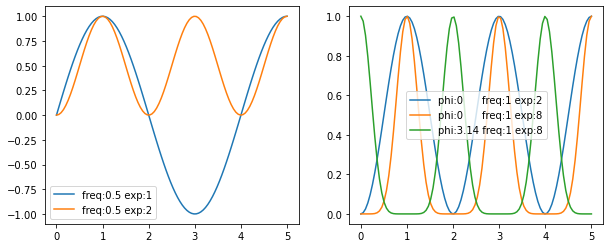

In [ ]:
# Examples of sum of gaussians
x = np.linspace(0,5,100)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(x, sin_exponent(x, amp=1, phi=0, freq=0.5, exp=1), label="freq:0.5 exp:1")
plt.plot(x, sin_exponent(x, amp=1, phi=0, freq=0.5, exp=2), label="freq:0.5 exp:2")
_ = plt.legend()

plt.subplot(1,2,2)
plt.plot(x, sin_exponent(x, amp=1, phi=0, freq=0.5, exp=2), label=    "phi:0      freq:1 exp:2")
plt.plot(x, sin_exponent(x, amp=1, phi=0, freq=0.5, exp=8), label=    "phi:0      freq:1 exp:8")
plt.plot(x, sin_exponent(x, amp=1, phi=np.pi, freq=0.5, exp=8), label="phi:3.14 freq:1 exp:8")
_ = plt.legend()

In [ ]:
#export
def sinexp_sigm(x, sigma, x0, y0, amp, phi, freq, exp):
    """A sine exponent weighted by a sigmoid. For parameters, see `sigmoid` and `sin_exponent`.
    However the amp and y0 (baseline) parameters are shared between the two sub-functions"""
    return sin_exponent(x, amp, phi, freq, exp) * sigmoid(x, sigma, 1, x0, 0) + y0

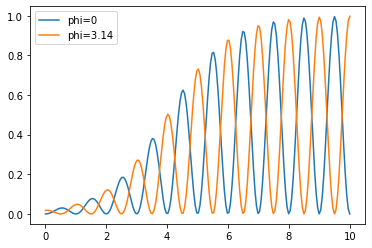

In [ ]:
# Examples of sum of gaussians
x = np.linspace(0,10,200)
plt.figure()
plt.plot(x, sinexp_sigm(x, sigma=1, x0=4, y0=0, amp=1, phi=0, freq=1, exp=2), label="phi=0")
plt.plot(x, sinexp_sigm(x, sigma=1, x0=4, y0=0, amp=1, phi=np.pi, freq=1, exp=2), label="phi=3.14")
_ = plt.legend()

# Fitting functions

In [ ]:
#export
def fit_sigmoid(nonlin, t=None):
    """Fit a sigmoid to a 1D input. Used to fit the nonlinearities of the cells responses.
    Also, the data must be increasing (from left to right).
    params:
        - nonlin: 1D data to fit
        - t     : timepoints of the data to fit. Same lenght as nonlin
        
    return:
        - A dictionary containing the parameters of the fit for a `sigmoid` 
        - A quality index of the fit (explained variance of the model)"""
    
    assert np.mean(nonlin[:20])<np.mean(nonlin[-20:]), "Nonlinearity must be increasing from left to right"
    if t is None:
        t = np.arange(len(nonlin))
    bounds = ([0.000001, 0.000001, -np.inf, 0],
              [np.inf  , np.inf,    np.inf, np.max(nonlin)])
    try:
        fit, _ = sp.optimize.curve_fit(sigmoid, t, nonlin, maxfev=1000000, bounds=bounds)
        fit  = {"sigma":fit[0],"amp":fit[1],"x0":fit[2],"y0":fit[3]}
    except RuntimeError:
        fit = {"sigma":1,"amp":0,"x0":0,"y0":0}
    model = sigmoid(t, **fit)
    quality_index =  1 - (np.var(nonlin-model)/np.var(nonlin))
    return fit, quality_index    

def fit_spatial_sta(sta):
    """Fit a sum of 2D gaussian to a 2D matrix. Used to fit the STA obtained from checkerboard like stimulus.
    params:
        - sta: 2D data to fit
        
    return:
        - A dictionary containing the parameters of the fit for a `sum_of_2D_gaussian` 
        - A quality index of the fit (explained variance of the model)"""
    shape_y, shape_x = sta.shape
    eps = 0.000001
    argmax = np.unravel_index(sta.argmax(), sta.shape)
    argmin = np.unravel_index(sta.argmin(), sta.shape)
    #                   sigma_x    sigma_z   amp theta      x0        z0      y0
    bounds_center   = ((0,         0,         0,  0,         0,       0,       0),
                       (shape_x*4, shape_y*4, 2,  2*math.pi, shape_x, shape_y, eps))
    if sta[argmax] < abs(sta[argmin]):
        argmax, argmin  = argmin, argmax
        bounds_center   = ((0,         0,        -2,  0,         0,       0,       0),
                           (shape_x*4, shape_y*4, 0,  2*math.pi, shape_x, shape_y, eps))
                       
    x    = np.arange(shape_x)
    z    = np.arange(shape_y)
    x, z = np.meshgrid(x, z)
    #                   sigma_x sigma_z  amp        theta      x0        z0       y0
    init_fit_center   = (  1,     1,    sta[argmax],  0,   argmax[1],  argmax[0], 0)
    data_tofit          = sta.reshape(-1)
    if np.isnan(sp.sum(sta)): #We check that the sta exists, otherwise return default zero model
        fit  = {"sigma_x_1": 1, "sigma_z_1":1, "amp_1":0, "theta_1":0, "x0_1":0, "z0_1":0,
                "sigma_x_2": 1, "sigma_z_2":1, "amp_2":0, "theta_2":0, "x0_2":0, "z0_2":0, "y0":0}
    else:
        try:
            fit_c, _   = sp.optimize.curve_fit(gaussian_2D, (x,z), data_tofit, p0=init_fit_center, bounds=bounds_center)
            tmp_to_fit =  data_tofit - gaussian_2D((x,z), *fit_c)
            #                   sigma_x    sigma_z   amp theta        x0            z0           y0
            bounds_surround = ((0,         0,        -2,  0,         fit_c[4],     fit_c[5],     0),
                               (shape_x*4, shape_y*4, 0,  2*math.pi, fit_c[4]+eps, fit_c[5]+eps, eps))
            init_fit_surround = (  2,      2,         0,  0,         fit_c[4],     fit_c[5],     0)
            fit_s, _   = sp.optimize.curve_fit(gaussian_2D, (x,z), tmp_to_fit, p0=init_fit_surround, bounds=bounds_surround)
                       
            init_fit_sum = (*fit_c[:-1],*fit_s[:-1],0)
            #Bounding only the position, that center fit should have found
            bounds_sum   = ((-np.inf,-np.inf,-np.inf,-np.inf,fit_c[4],fit_c[5],
                             -np.inf,-np.inf,-np.inf,-np.inf,fit_c[4],fit_c[5],-np.inf),
                            (np.inf, np.inf, np.inf, np.inf, fit_s[4]+eps,fit_s[5]+eps,
                             np.inf,np.inf,np.inf,np.inf,fit_s[4]+eps,fit_s[5]+eps,np.inf))
            fit_sum, _ = sp.optimize.curve_fit(sum_of_2D_gaussian, (x,z), data_tofit, p0=init_fit_sum, bounds=bounds_sum)
            fit  = {"sigma_x_1": fit_sum[0], "sigma_z_1":fit_sum[1], "amp_1":fit_sum[2], 
                    "theta_1":fit_sum[3], "x0_1":fit_sum[4], "z0_1":fit_sum[5],
                    "sigma_x_2": fit_sum[6], "sigma_z_2":fit_sum[7], "amp_2":fit_sum[8], 
                    "theta_2":fit_sum[9], "x0_2":fit_sum[10], "z0_2":fit_sum[11], "y0":fit_sum[12]}

        except RuntimeError: #If a model can't be fitted, we get a runtimeError
            fit  = {"sigma_x_1": 1, "sigma_z_1":1, "amp_1":0, "theta_1":0, "x0_1":0, "z0_1":0,
                    "sigma_x_2": 1, "sigma_z_2":1, "amp_2":0, "theta_2":0, "x0_2":0, "z0_2":0, "y0":0}
    model = sum_of_2D_gaussian((x,z), **fit)
    quality_index = 1 - (np.var(data_tofit-model)/np.var(data_tofit))
    return fit, quality_index


In [ ]:
#export
def fit_temporal_sta(sta, frame_rate=60):
    """Fit a sum of gaussian to a 1D input. Used to fit the STA obtained from fullfield flicker like stimulus.
    params:
        - sta: 1D data to fit

    return:
        - A dictionary containing the parameters of the fit for a `diff_of_gaussian`. The parameter with _1 suffix
        correspond to the closest gaussian to the zero timepoint.
        - A quality index of the fit (explained variance of the model)"""
    
    # Cutting out the tail of the tSTA to increase the fitting error of the "interesting" part
    cell_abs = np.abs(sta)
    startSTA   = len(sta)-np.argmax(cell_abs>(cell_abs.max()*.4))
    startSTA  += np.maximum(5,(startSTA*.5)).astype(int)
    fullsta = sta.copy()
    sta = sta[-startSTA:]
    
    t = np.linspace((1-len(sta))/frame_rate, 0, len(sta))

                #sigma_1, amp_1,   x0_1,                sigma_2, amp_2,  x0_2,       
    bounds   = ((0,       0,      -len(sta)/frame_rate, 0,       0,      -len(sta)/frame_rate),
                (.1,      np.inf, 1/frame_rate,        .1,       np.inf, 1/frame_rate))
    
    diff_of_gauss = partial(diff_of_gaussian, y0=0)

    if np.isnan(sp.sum(sta)): #We check that the sta exists, otherwise return default zero model
        fit  = {"sigma_1":1,"amp_1":0,"x0_1":0,
                "sigma_2":1,"amp_2":0,"x0_2":0,"y0":0}
    else:
        try:
            fit, _ = sp.optimize.curve_fit(diff_of_gauss, t, sta, bounds=bounds, max_nfev=100000000000)

            fit  = {"sigma_1":fit[0],"amp_1":fit[1],"x0_1":fit[2],
                    "sigma_2":fit[3],"amp_2":fit[4],"x0_2":fit[5],"y0":0}
        except RuntimeError: #If a model can't be fitted, we get a runtimeError
            fit  = {"sigma_1":1,"amp_1":0,"x0_1":0,
                    "sigma_2":1,"amp_2":0,"x0_2":0,"y0":0}

    t = np.linspace((1-len(fullsta))/frame_rate, 0, len(fullsta))

    model = diff_of_gaussian(t, **fit)
    quality_index = 1 - (np.var(fullsta-model)/np.var(fullsta))
    return fit, quality_index
    

In [ ]:
#export
def fit_chirp_am(cell_mean, start=420, stop=960, freq=1.5, frame_rate=60):
    """Fit a sinexp_sigm to the mean response of a cell to chirp_am stimulus.
    params:
        - cell_mean: Average response of the cell to the chirp_am stimulus
        - start:     Index in the cell mean where to start the fitting
        - stop:      Index in the cell mean where to stop the fitting
        - freq:      Frequency of the amplitude modulation of the stimulus in Hz
    
    return :
        - A dictionary containing the parameters of the fit for a `sinexp_sigm` 
        - A quality index of the fit (explained variance of the model)"""

    to_fit = cell_mean[start:stop]
    t = np.linspace(0, len(to_fit)/frame_rate, len(to_fit), endpoint=False)
    
    #If suppressed by contrast cell, the firing should be higher in first part of chirp
    fit_positive = np.mean(to_fit[:len(to_fit)//3]) < np.mean(to_fit[len(to_fit)*2//3:])

    tmp_diff = np.inf
    best_fit = (1, 0, 0, 0, 0, freq, 0)
    phi      = np.pi
    for exp in np.exp2(range(1,10)): #Fitting the data with different sin exponents, to narrow the fit
        try:
            sinexp_sigm_part = partial(sinexp_sigm, freq=freq, exp=exp)
            if fit_positive:
                fit, _ = sp.optimize.curve_fit(sinexp_sigm_part, t, to_fit, 
                                               bounds=[(  0,    0          ,        0       ,      0        , 0),
                                                        (50, len(to_fit)/60,  np.max(to_fit), np.max(to_fit), 2*np.pi)],
                                               p0 =      (1, len(to_fit)/120,       0       , np.max(to_fit), phi),
                                              maxfev=100000)
            else:
                fit, _ = sp.optimize.curve_fit(sinexp_sigm_part, t, to_fit, 
                                               bounds=[(  0,    0          ,        0       ,-np.max(to_fit), 0),
                                                        (50, len(to_fit)/60,  np.max(to_fit),     0         , 2*np.pi)],
                                               p0 =     (1, len(to_fit)/120,  np.max(to_fit) ,-np.max(to_fit),phi),
                                              maxfev=100000)
                
            mse = np.sum(np.square(sinexp_sigm_part(t, *fit) - to_fit))
            phi = fit[4]
            if mse < tmp_diff:
                best_fit = (*fit, freq, exp)
                tmp_diff = mse
        except:
            continue
    best_fit = dict((k, v) for v, k in zip(best_fit, ["sigma","x0","y0","amp","phi","freq","exp"]))

    model  = sinexp_sigm(t, **best_fit)
    to_fit = cell_mean[start:stop]
    quality_index = 1 - (np.var(to_fit-model)/np.var(to_fit))
    return best_fit, quality_index

def fit_chirp_freq_epoch(cell_mean, start=360, freqs=[1.875,3.75,7.5,15,30], durations=[2,2,2,1,1], frame_rate=60):
    """Fit multiple sinexp_sigm to the mean response of a cell to chirp_freq_epoch stimulus.
    Each epoch is fitted independantly by a `sin_exponent`
    params:
        - cell_mean: Average response of the cell to the chirp_am stimulus
        - start:     Index in the cell mean where to start the fitting
        - freqs:     Frequencies of each epoch in Hz
        - durations: Duration of each epoch in seconds
        - freq:      Frequency of the amplitude modulation of the stimulus
    
    return :
        - List of dictionary containing the parameters of each epoch fit for a `sin_exponent` 
        - List of quality index of each epoch fit (explained variance of the model)"""
    best_fit_l = []
    qualityidx_l = []

    cursor = start #Start of the freqs
    
    #We fit each freqency epoch with a cos function
    for freq, dur in zip(freqs, durations):
        n_rep, n_fr = int(dur*freq), int(frame_rate/freq)
        edgecut = 10
        cursor += edgecut
        len_fit = n_rep*n_fr - edgecut      
        
        #Upsampling of the data to prevent low sampling effects with high freq sine
        upsamp = 10
        to_fit = cell_mean[cursor:cursor+len_fit+1]
        t = np.linspace(0, len_fit/frame_rate, len_fit*upsamp, endpoint=False)
        to_fit = interp1d(np.linspace(0,len(to_fit)/frame_rate, len(to_fit), endpoint=False), to_fit)(t)

        best_fit = None
        tmp_diff = np.inf
        for exp in np.exp2(range(1,10)): #Fitting the data with different cos exponents, to narrow the fit
            try:
                sin_exponent_part = partial(sin_exponent, freq=freq, exp=exp)
                fit, cov = sp.optimize.curve_fit(sin_exponent_part, t, to_fit, bounds=[(0,          0),
                                                                                       (max(to_fit),np.pi*2)])
                mse = np.sum(np.square(sin_exponent_part(t, *fit) - to_fit))
                if mse < tmp_diff:
                    best_cov = cov
                    best_fit = (*fit, freq, exp)
                    tmp_diff = mse
            except:
                continue
        if best_fit is not None:
            best_fit = dict((k, v) for v, k in zip(best_fit, ["amp","phi","freq","exp"]))
            best_fit_l.append(best_fit)
            model = sin_exponent(t, **best_fit)
            qualityidx_l.append(1 - (np.var(to_fit-model)/np.var(to_fit)))
        else:
            best_fit_l.append({"amp":0,"phi":0,"freq":freq,"exp":0})
            qualityidx_l.append(0)
        
        cursor += len_fit
    return best_fit_l, qualityidx_l #, best_cov_l

In [ ]:
#export
def fit_transiency(pref_response, frame_rate=60):
    """Fit an exponential decay to a 1D input. Used to fit the response of cells to their preferred
    sustained stimulus. 
    params:
        - pref_response: 1D data to fit

    return:
        - A dictionary containing the parameters of the fit for a `exponential_decay` 
        - A quality index of the fit (explained variance of the model)"""
    peak_position = np.argmax(pref_response)
    pref_response = pref_response[peak_position:]

    t = np.linspace(0, len(pref_response)/frame_rate, len(pref_response), endpoint=False)
    bounds = ([0.000001, 0],
              [np.inf  , pref_response[0]])
    if np.all(pref_response==0):
        fit = {"tau":1,"baseline":0,"amplitude":0}
    else:
        try:
            decay_part = partial(exponential_decay, amplitude=pref_response[0])
            fit, _ = sp.optimize.curve_fit(decay_part, t, pref_response, maxfev=1000000, bounds=bounds)
            fit  = {"tau":fit[0],"baseline":fit[1],"amplitude":pref_response[0]}
        except RuntimeError:
            fit = {"tau":1,"baseline":0,"amplitude":0}
    model = exponential_decay(t, **fit)
    quality_index =  1 - (np.var(pref_response-model)/np.var(pref_response))

    return fit, quality_index, peak_position

In [ ]:
#export
def repetition_quality_index(cell_response):
    """Return a quality index of cell response to a repeated stimulus.
    params:
        - cell_response: response of a cell of shape (n_rep, time)"""
    tmp1 = np.var(np.mean(cell_response, axis=0)) #VAR(MEAN(C)repeat)time
    tmp2 = np.mean(np.var(cell_response, axis=0)) #MEAN(VAR(C)time)repeat
    quality = tmp1/tmp2
    return quality

def onoff_transient_index(cell_response, start_on=120, stop_on=240, start_off=240, stop_off=360):
    """Return both on-off and transient indexes of cell response. Transiency index is not always 
    ideal to describe the cells response. Consider fitting an exponential decay with `fit_transiency`.
    params:
        - cell_response: response of a cell of shape (time,...)
        - start_on:  starting index of ON stimulation
        - stop_on:   stop index of ON stimulation
        - start_off: starting index of OFF stimulation
        - stop_off:  stop index of OFF stimulation
    return:
        - ON-OFF index
        - Transiency index"""
    #ON-OFF index
    on_response   = cell_response[start_on:stop_on]
    on_sum        = np.sum(on_response)
    off_response  = cell_response[start_off:stop_off]
    off_sum       = np.sum(off_response)
    onoff_indexes = (on_sum-off_sum)/(on_sum+off_sum)

    #Transient index
    if onoff_indexes>0: #Main ON response
        transient_sum   = np.sum(cell_response[start_on:start_on+30])
        sustained_sum   = np.sum(cell_response[start_on:stop_on])
    else:
        transient_sum   = np.sum(cell_response[start_off:start_off+30])
        sustained_sum   = np.sum(cell_response[start_off:stop_off])
    transient_index = transient_sum/sustained_sum
        
    return onoff_indexes, transient_index

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_utils.ipynb.
Converted 02_processing.ipynb.
Converted 03_modelling.ipynb.
Converted 04_plotting.ipynb.
Converted 05_database.ipynb.
Converted 06_eyetrack.ipynb.
Converted 10_synchro.io.ipynb.
Converted 11_synchro.extracting.ipynb.
Converted 12_synchro.processing.ipynb.
Converted 13_leddome.ipynb.
Converted 99_testdata.ipynb.
Converted index.ipynb.
